In [1]:
using Distributed
addprocs(8);

In [2]:
using PulseInputDDM

In [3]:
ncells = [3,3];

In [4]:
ntrials = [100,100];

In [5]:
f = [["Softplus" for n in 1:N] for N in ncells]

2-element Vector{Vector{String}}:
 ["Softplus", "Softplus", "Softplus"]
 ["Softplus", "Softplus", "Softplus"]

In [6]:
n, cross = 53, false

(53, false)

In [7]:
θ_generative = θneural_choice(θz=θz(σ2_i = 5., B = 15., λ = -0.5, σ2_a = 100., σ2_s = 0.5,
    ϕ = 0.4, τ_ϕ = 0.02), bias=1.0, lapse=0.05, θy=[[Softplus(rand([-2., 2.])) for n in 1:N] for N in ncells], 
    f = f);

In [8]:
data, μ_rnt, μ_t = synthetic_data(θ_generative, ntrials, ncells; centered=true, pos_ramp=true, dt_synthetic=1e-4,
    rng=3);

In [9]:
output = PulseInputDDM.process_spike_data.(μ_rnt, data; nconds=2);

In [10]:
μ_ct = getindex.(output, 1)
σ_ct = getindex.(output, 2);

In [11]:
model = neural_choiceDDM(θ_generative, n, cross)  

neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false


In [12]:
_, μ_c_λ, = simulate_expected_firing_rate(model, data; num_samples=100, nconds=2);

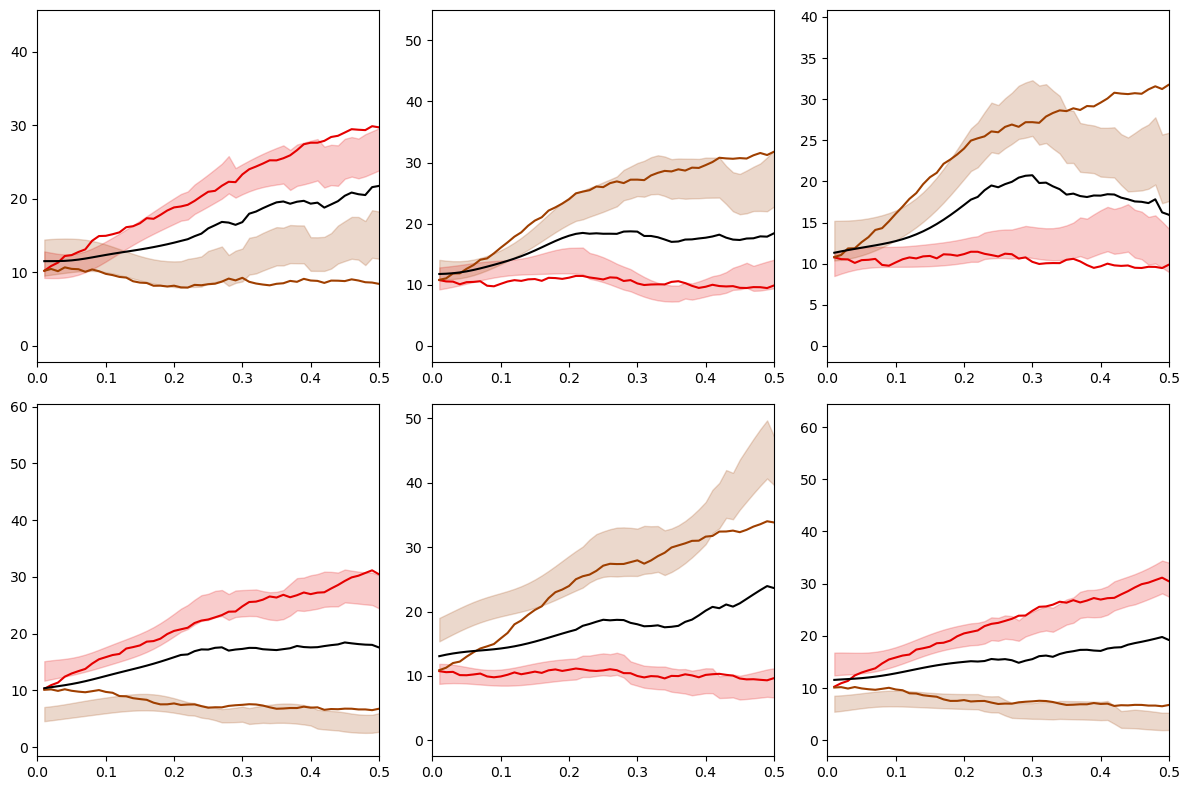

In [13]:
using PyPlot

dt = 1e-2

num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout()
display(gcf())

In [14]:
options = neural_choice_options(f)
lb, ub, fit = options.lb, options.ub, options.fit
ub[2] = 40.
options = neural_choice_options(fit=fit, lb=lb, ub=ub);

In [15]:
using Flatten

In [16]:
joint_loglikelihood(model, data)

-15579.022065483841

In [17]:
x0 = vcat([0.1, 20., -0.1, 20., 0.8, 0.01, 0.008], 
    [0., 1e-1], vcat(θy.(data, f)...)...);

In [18]:
model = neural_choiceDDM(θneural_choice(x0, f), n, cross)  

neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false


In [19]:
joint_loglikelihood(model, data)

-16149.754157378731

In [20]:
model, = choice_neural_optimize(model, data, options; iterations=1, outer_iterations=1, f_tol=1e-12, x_tol=1e-12)

Fminbox
-------
Initial mu = 0.0271842

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0271842

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.614863e+04     1.114455e+04
 * time: 0.006682157516479492

Exiting inner optimizer with x = [0.10000359820781055, 20.000004743920996, -0.09997654790340615, 20.000000951145513, 0.8000289936225223, 0.010020273159776959, 0.005342932557011062, 2.2197701489518068e-7, 0.10000166180048434, -0.5022707188947533, 0.5572821284742251, 0.562694041757218, -0.7167758872202, 0.76966076091763, -0.7166738360990202]
Current distance to box: 0.000342933
Decreasing barrier term μ.



(neural_choiceDDM{θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}}
  θ: θneural_choice{θz{Float64}, Float64, Vector{Vector{Softplus{Float64}}}}
  n: Int64 53
  cross: Bool false
,  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.612099e+04

 * Found with
    Algorithm:     Fminbox with BFGS

 * Convergence measures
    |x - x'|               = 2.66e-03 ≰ 1.0e-12
    |x - x'|/|x'|          = 9.39e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-12
    |g(x)|                 = 2.00e+01 ≰ 1.0e-03

 * Work counters
    Seconds run:   7  (vs limit 170000)
    Iterations:    1
    f(x) calls:    2
    ∇f(x) calls:   2
)

In [21]:
hcat(collect(PulseInputDDM.flatten(model.θ)), collect(PulseInputDDM.flatten(θ_generative)))

15×2 Matrix{Float64}:
  0.100004      5.0
 20.0          15.0
 -0.0999765    -0.5
 20.0         100.0
  0.800029      0.5
  0.0100203     0.4
  0.00534293    0.02
  2.21977e-7    1.0
  0.100002      0.05
 -0.502271     -2.0
  0.557282      2.0
  0.562694      2.0
 -0.716776     -2.0
  0.769661      2.0
 -0.716674     -2.0

In [22]:
_, μ_c_λ, = simulate_expected_firing_rate(model, data; num_samples=100, nconds=2);

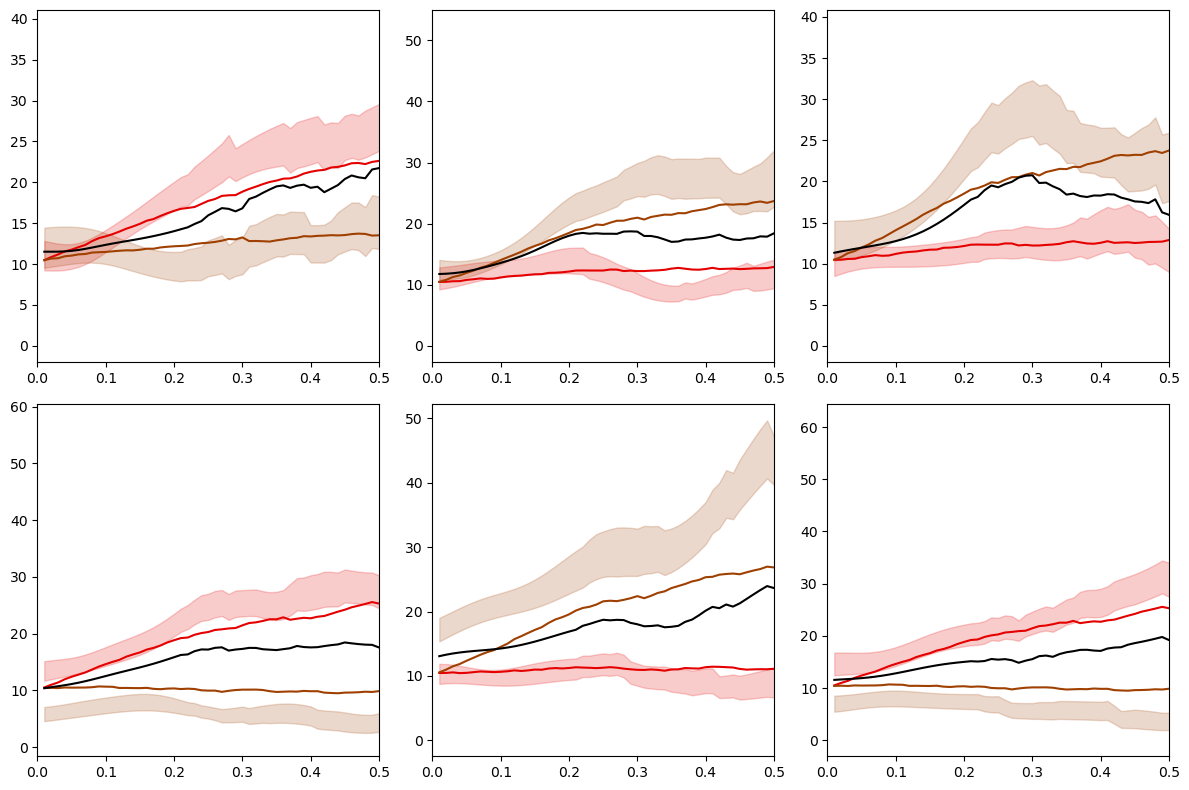

In [23]:
num_rows, num_cols = length(data), maximum(map(x-> x[1].ncells, data))
fig, ax = subplots(num_rows, num_cols, figsize=(4*maximum(map(x-> x[1].ncells, data)), 4*length(data)))
my_colors = ["#E50000","#9F3F00","#5A7F00","#15BF00"]

for i in 1:num_rows
        
    for j in 1:data[i][1].ncells             
        for k = 1:2     

            ax[i,j].fill_between((1:length(μ_ct[i][j][k]))*dt,
                μ_ct[i][j][k] + σ_ct[i][j][k],
                μ_ct[i][j][k] - σ_ct[i][j][k],
                alpha=0.2, color=my_colors[k])

            ax[i,j].plot((1:length(μ_c_λ[i][j][k]))*dt,
                μ_c_λ[i][j][k], color=my_colors[k])                                     

            ax[i,j].set_xlim((0, 0.5))
                        
        end   
        
        ax[i,j].plot((1:length(μ_t[i][j]))*dt,
            μ_t[i][j], color="black")

    end
    
end

tight_layout()
display(gcf())

In [24]:
H = Hessian(model, data)

15×15 Matrix{Float64}:
   67.7277         -0.811131       -1.66028    …     -1.62262       1.48751
   -0.811131        3.30391        -6.13811           3.11009      -1.21328
   -1.66028        -6.13811        28.8484           10.4139      -11.3563
    0.166909       -0.214412        0.58399          -0.163417      0.173405
    7.49419       -10.7785         24.5251           -9.09948       7.27046
    2.04005        -5.7061         23.4209     …     12.0085      -18.9107
 -396.428        1084.47        -4424.12          -2019.65       3498.98
    0.000684463    -0.00992331     -0.0795156         0.0617087    -0.260687
    1.95142         0.624428        2.36627           1.4162      -17.6016
    3.00529         2.8219          4.77763          -0.0          -0.0
   -1.67839        -1.38549         3.56914    …     -0.0          -0.0
   -2.96437        -2.4863         -4.54365          -0.0          -0.0
    0.786424       -2.7121         -9.82692          19.5402      -37.9764
   -1.

In [25]:
using LinearAlgebra

In [26]:
eigvals(H)

15-element Vector{Float64}:
 -155.07616275786324
    0.049202856353067245
    0.8672417300184991
    1.3978661327691724
   16.8809122233906
   67.39160732232615
  144.4614447647259
  244.36268368594133
  301.27112288436945
  383.7034736491162
  415.1125500375207
  482.43325065143574
  544.2339937133842
  790.3305087138517
    1.3463432915840584e6

In [27]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=1e-2, centered=false), getfield.(vcat(data...), :input_data));
choice_data = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data...), :choice));
choices = getfield.(choice_data, :choice);

In [28]:
x = PulseInputDDM.flatten(model.θ);

In [29]:
syn_choices = rand.(Ref(Flatten.reconstruct(θchoice(), x[1:9])), choice_inputs, 1:length(choice_inputs));

In [30]:
output = map(x-> binLR(x.click_data.binned_clicks, x.click_data.clicks, x.click_data.dt), choice_data);
L,R = getindex.(output,1), getindex.(output,2);
ΔLR = last.(cumsum.(-L .+ R));

In [31]:
using Optim, LineSearches, ForwardDiff, Distributions
w0 = [0.1, 1., 0.];

In [32]:
mylogit(w) = (w[1]/2 .+ (1 .- w[1]) ./ (1. .+ exp.(-w[2]*ΔLR .+ w[3])));
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), choices))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
m = BFGS(alphaguess = InitialStatic(alpha=1.0,scaled=true), linesearch = BackTracking());
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_data = Optim.minimizer(output);

In [33]:
xs = sort(ΔLR);
idxs = sortperm(ΔLR)
y_data = mylogit(what_data)[idxs];

In [34]:
ll(w) = -1 * sum(logpdf.(Bernoulli.(vec(mylogit(w))), syn_choices))
obj = OnceDifferentiable(ll, w0; autodiff=:forward)
output = Optim.optimize(obj, [0, -Inf, -Inf], [1., Inf, Inf], w0, Fminbox(m));
what_syn = Optim.minimizer(output);

In [35]:
y_syn = mylogit(what_syn)[idxs];

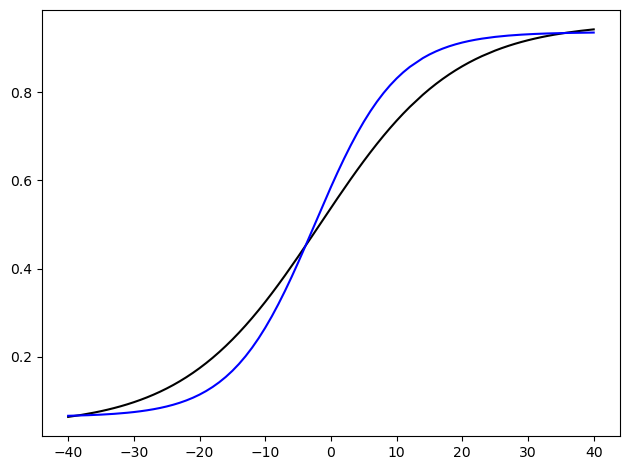

In [36]:
fig, ax = subplots(1, 1)
ax.plot(xs, y_data, label="data", color="black", linestyle="-")
ax.plot(xs, y_syn, label="syn", color="blue", linestyle="-")
tight_layout()
display(gcf())

In [37]:
x = 1

1